In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def logprior(b, sigma2):
    return -np.log(sigma2)

def logistic(x, b):
    #x[0]: t
    #x[1]: h
    #x[2]: w
    theta = b[0] + x[0]*b[1] + x[1]*b[2] + x[2]*b[3] + x[3]*b[4]
    return 1.0/(1+np.exp(theta))

def loglikelihood(b, sigma2, x, y):
    n = len(x)
    return -n*np.log(sigma2) - 0.5*((y-logistic(x, b))**2).sum()/sigma2

def logpost(b, sigma2, x, y):
    return logprior(b, sigma2) + loglikelihood(b, sigma2, x, y)

In [3]:
# mcmc algorithm
def mcmc(b_init, sig2, x, y, N, burnin, be, sig2e):
    B = np.zeros((N,len(b_init)))
    Sig2 = np.zeros(N)
    
    b_prev = b_init
    sig2_prev = sig2
    count = 0
    r = np.random.random(N)
    
    for i in xrange(N):
        b_star = np.random.normal(b_prev,be)

        sig2_star = abs(np.random.normal(sig2_prev, sig2e))
        
        p = logpost(b_star, sig2_star, x, y) - logpost(b_prev, sig2_prev, x, y)
        if np.log(r[i]) < p:
            b_prev = b_star
            sig2_prev = sig2_star
            count += 1
                           
        B[i] = b_prev
        Sig2[i] = sig2_prev
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return B, Sig2

In [5]:
#import data and labels
train_data = pd.read_csv('Waterpump-training-values.csv')
train_labels = pd.read_csv('Waterpump-training-labels.csv')

#separating dataset into training and testing for cross-validation - 90% into training
test_idx = np.random.uniform(0, 1, len(train_data)) <= 0.9
train = train_data[test_idx==True]
trainLabels = train_labels[test_idx==True]
test = train_data[test_idx==False]
testLabels = train_labels[test_idx==False]

In [6]:
features = ['longitude','latitude']
trainLoc = train[features]
hasLocIdx = trainLoc['longitude']>1
trainLoc = trainLoc[hasLocIdx] #remove rows with empty location data
trainLabelsLoc = trainLabels[hasLocIdx] #only keep labels corresponding to rows with non-empty location data

In [7]:
nNeighbors = 60
clf = KNeighborsClassifier(n_neighbors=nNeighbors,weights='distance',algorithm='auto')
clf.fit(trainLoc[features], trainLabelsLoc['status_group'])
#preds = clf.predict(test[features])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=60, p=2, weights='distance')

In [8]:
features=['construction_year', 'gps_height']
trainFeatures = train[features]
trainFeatures['age'] = 2015 - trainFeatures['construction_year']
trainFeatures = trainFeatures.drop('construction_year', 1)

In [9]:
probaPredict = clf.predict_proba(trainFeatures)
kNNFunctional = probaPredict[:,0]
knnNeedsRepair = probaPredict[:,1]
kNNnonFunctional = probaPredict[:,2]
#TODO: get more meaningful data out of kNN algorithm?
x = np.vstack((trainFeatures['age'],trainFeatures['gps_height'],kNNFunctional,kNNnonFunctional))

In [10]:
numFeatures = 4
numBeta = numFeatures + 1  #1 more for the constant
#TODO: Convert labels into numbers
trainLabelsVect = pd.get_dummies(trainLabels['status_group'])
trainLabelsVect['functionality'] = trainLabelsVect['functional'] + 0.5*trainLabelsVect['functional needs repair']

In [37]:
B, sig2= mcmc(np.zeros(numBeta), 0.2, x, trainLabelsVect['functionality'], 50000, 0, 0.1, 0.1)

The acceptance rate is 0.00336.


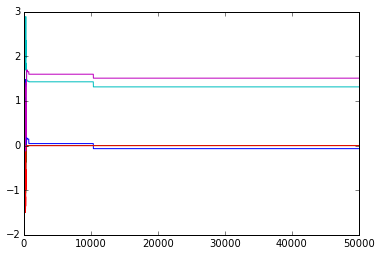

In [38]:
plt.plot(B[:,0])
plt.plot(B[:,1])
plt.plot(B[:,2])
plt.plot(B[:,3])
plt.plot(B[:,4])

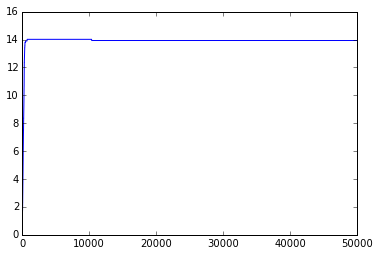

In [39]:
plt.plot(sig2)

In [40]:
b_final = B[-1,:]

In [41]:
b_final

array([ -6.99730186e-02,  -6.41988594e-04,  -2.34575944e-03,
         1.31367565e+00,   1.50905415e+00])

In [16]:
#transforming test data
features=['construction_year', 'gps_height']
testFeatures = test[features]
testFeatures['age'] = 2015 - testFeatures['construction_year']
testFeatures = testFeatures.drop('construction_year', 1)
probaPredictTest = clf.predict_proba(testFeatures)
kNNFunctionalTest = probaPredict[:,0]
knnNeedsRepairTest = probaPredict[:,1]
kNNnonFunctionalTest = probaPredict[:,2]
#TODO: get more meaningful data out of kNN algorithm?
xTest = np.vstack((trainFeatures['age'],trainFeatures['gps_height'],kNNFunctionalTest,kNNnonFunctionalTest))

In [42]:
#predictions - these are the continuous values, need to convert to labels
yPredict = logistic(xTest, b_final)

In [43]:
n = len(testLabels)
correct = 0.0
for yPred, label in zip(yPredict, testLabels['status_group']):
    if yPred >= 0.66 and label=='functional':
        correct += 1
    elif yPred <= 0.33 and label == 'non functional':
        correct += 1
    elif yPred > 0.33 and yPred < 0.66 and label == 'functional needs repair':
        correct += 1
print correct/n

0.311070295542


(array([  3816.,   2821.,   2968.,   1497.,  18655.,   1467.,   2391.,
          3921.,   8412.,   7463.]),
 array([ 0.20742442,  0.28614536,  0.3648663 ,  0.44358723,  0.52230817,
         0.60102911,  0.67975005,  0.75847099,  0.83719193,  0.91591287,
         0.99463381]),
 <a list of 10 Patch objects>)

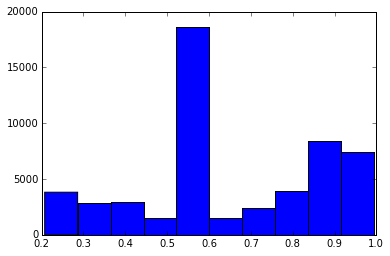

In [44]:
plt.hist(yPredict)